In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time
import scipy

from final.model import Model
from final.helpers import Helpers
from final.datahandler import DataHandler
from final.dihedralcalculator import DihedralCalculator

In [2]:
import data_loader as dl
import data_transformer as dt
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '/home/mikey/Data/ProteinNet/casp7_txt/'

max_len = None # max len of the protein taken into account
n_angles = 3 # 3 if consider all angles or 2 if only phi and psi

file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))

if max_len == None:
    max_len = np.max(np.array([prim.shape[0] for prim in prim_valid]))
    print('max_len set to', max_len)

prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v[:,:,:n_angles]

x_valid.shape, y_valid.shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 224/224 [00:00<00:00, 63502.81it/s]

Grouped 21's together
Loaded data and filtered line endings
Extracted mask data
max_len set to 696
padded
(224,) (269, 20)
padded
(224,) (269, 21)
padded
(224,) (269, 3)
padded
(224,) (269, 1)


((224, 696, 41), (224, 696, 3))

In [3]:
def _coordinates(config, dihedrals):
    """ Converts dihedrals into full 3D structures. """

    # converts dihedrals to points ready for reconstruction.
    points = dihedral_to_point(dihedrals) # [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]
             
    # converts points to final 3D coordinates.
    coordinates = point_to_coordinate(points, num_fragments=config['num_reconstruction_fragments'], 
                                              parallel_iterations=config['num_reconstruction_parallel_iters']) 
                  # [NUM_STEPS x NUM_DIHEDRALS, BATCH_SIZE, NUM_DIMENSIONS]

    return coordinates

def _drmsds(config, coordinates, targets, weights):
    """ Computes reduced weighted dRMSD loss (as specified by weights) 
        between predicted tertiary structures and targets. """
                  
    # compute per structure dRMSDs
    drmsds = drmsd(coordinates, targets, weights, name='drmsds') # [BATCH_SIZE]

    # add to relevant collections for summaries, etc.
    if config['log_model_summaries']: tf.add_to_collection(config['name'] + '_drmsdss', drmsds)

    return drmsds

tf.reset_default_graph()
helpers = Helpers()

# parameters for the training and
# queues that control data flow from files
data_path = "/home/mikey/Data/ProteinNet/"
# training_percentages = [30, 50, 70, 90, 95, 100]
casps = ['casp7']
training_percentages = [30, 50, 70, 90, 95]

num_epochs = 100
batch_size= 32
capacity=1000
# min_after_dequeue=100

max_protein_len = None
model_type = 'cnn_big'
angularization_mode = 'tanh'
apply_mask = True
loss_mode = 'angular_mae' # angular_mae or mae
include_evo = True

# define the training data paths and how many epochs they should be queued for
# by instantiating the DataHandler object that takes care of parsing
data_handler = DataHandler(data_path=data_path,
                           casps=casps,
                percentages=training_percentages, 
                num_epochs=num_epochs)

# use DataHandler to generate batches of specific size 
# and optional limit on protein length
ids, one_hot_primary, evolutionary, _, tertiary, ter_mask, pri_length, keep =\
    data_handler.generate_batches(batch_size = batch_size,
                                  capacity = capacity,
                                  max_protein_len = max_protein_len)
# if max_protein_len:
#     ids, one_hot_primary, evolutionary, tertiary, ter_mask, pri_length =\
#         helpers.mask_all([ids, one_hot_primary, evolutionary, tertiary, ter_mask, pri_length], keep, axis=0)

# convert euclidean coordinates to dihedral angles
dihedral_calculator = DihedralCalculator()
true_dihedrals = dihedral_calculator.dihedral_pipeline(tertiary, protein_length = tf.shape(one_hot_primary)[1])

# set up placeholders with batch_size=None to be able to feed them with validation data
# they fall onto default coming from the queue if nothing is fed through feed_dict
true_dihedrals = tf.placeholder_with_default(true_dihedrals, shape=(None, None, 3))
one_hot_primary = tf.placeholder_with_default(one_hot_primary, shape=(None, None, 20))
evolutionary = tf.placeholder_with_default(evolutionary, shape=(None, None, 21))
ter_mask = tf.placeholder_with_default(ter_mask, shape=(None, None))

if include_evo:
    input_data = tf.concat([one_hot_primary, evolutionary], axis=2)
else:
    input_data = one_hot_primary

# build a model and get predicted output
pred = Model(model_type=model_type, 
             ang_mode=angularization_mode
            ).build_model(input_data)

# mask values (gets reshaped into 2 dimensions)
# it's important to note that with apply_mask = False the validation
# loss and trianing loss are not related. This is likely
# due to padding being done differently on validation and training data
true_dihedrals_masked, pred_masked = true_dihedrals, pred
if apply_mask:
    true_dihedrals_masked, pred_masked = helpers.mask_all([true_dihedrals, pred], ter_mask)

# angular mae. 1 value per angle
loss_vec = helpers.loss360(true_dihedrals_masked, pred_masked)
# reduced to 1 value
loss = tf.reduce_mean(loss_vec)

# mae. 1 value per angle
mae_vec = Helpers.mae(true_dihedrals_masked, pred_masked)
# reduced to 1 number
mae = tf.reduce_mean(mae_vec)

# learning rate placeholder for adaptive learning rate
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# choose an optimizer to minimize the loss
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

train_op = {
    'angular_mae': optimizer.minimize(loss, global_step=global_step),
    'mae': optimizer.minimize(mae, global_step=global_step)
}[loss_mode]
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

['/home/mikey/Data/ProteinNet/casp7/training/30/*', '/home/mikey/Data/ProteinNet/casp7/training/50/*', '/home/mikey/Data/ProteinNet/casp7/training/70/*', '/home/mikey/Data/ProteinNet/casp7/training/90/*', '/home/mikey/Data/ProteinNet/casp7/training/95/*']
Training samples available 74113
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


/home/mikey/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training loop

In [ ]:
learning_rate_decay = 0.98
steps_to_print_after = 500
init_learning_rate = 0.001

if 'lstm' in model_type:
    init_learning_rate = 0.001
    steps_to_print_after = 400
    
with tf.Session() as sess:
    # important to call both of these, because 
    # otherwise can't specify num_epochs in string_input_producer
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)

    try:
        # we can't access information from the queue
        # to know when an epoch ends, so we define our
        # own step counter and calculate an validation loss every n steps
        step = 1
        
        losses = []
        loss_vecs = []
        avg_losses = []
        
        while not coord.should_stop():        
                
            _, true_dihedrals_, pred_, loss_, loss_vec_ = sess.run([train_op, true_dihedrals, 
                                                                    pred, loss, loss_vec], 
                                                                    feed_dict={learning_rate: init_learning_rate})

            losses.append(loss_)
            loss_vecs.append(loss_vec_)
            if step % steps_to_print_after == 0:
                avg_loss, avg_loss_vec =  np.mean(losses), np.mean(np.array(loss_vecs), axis=0)
                avg_losses.append(avg_loss)
                print("Vec loss:", avg_loss_vec)
                print("Avg loss:", avg_loss)

                losses = []
                loss_vecs = []
                
                (true_dihedrals_v, pred_v, 
                 loss_, loss_vec_, 
                 mae_, mae_vec_) = sess.run([true_dihedrals_masked, pred_masked, 
                                                   loss, loss_vec,
                                                   mae, mae_vec], 
                                                   feed_dict={
                                                           one_hot_primary: prim_v,
                                                           evolutionary: evo_v,
                                                           true_dihedrals: dih_v,
                                                           ter_mask: mask_v
                                                          })
                print("Validation loss:", loss_, loss_vec_)
                print("Validation mae:", mae_, mae_vec_)
                print("Validation PCC:", Helpers.pearson_numpy(true_dihedrals_v, pred_v))
            
            if step * batch_size > data_handler.training_samples:
                step = 0
                init_learning_rate = init_learning_rate * learning_rate_decay
                print("EPOCH. New learning rate:", init_learning_rate)
                
            step += 1


    except tf.errors.OutOfRangeError:
        print('Done training for %d epochs, %d steps.' % (num_epochs, step))
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        sess.close()

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Plot the avg losses over time

In [ ]:
plt.plot(avg_losses)

Get just the dihedral angles to see if they resemble how a ramachadran plot should look like

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)
    
    true_dihedrals_, ohp, tert = sess.run([true_dihedrals, one_hot_primary, tertiary])
    coord.request_stop()

In [ ]:
np.mean(np.abs(true_dihedrals_v - pred_v)), loss_

In [ ]:
phi.shape

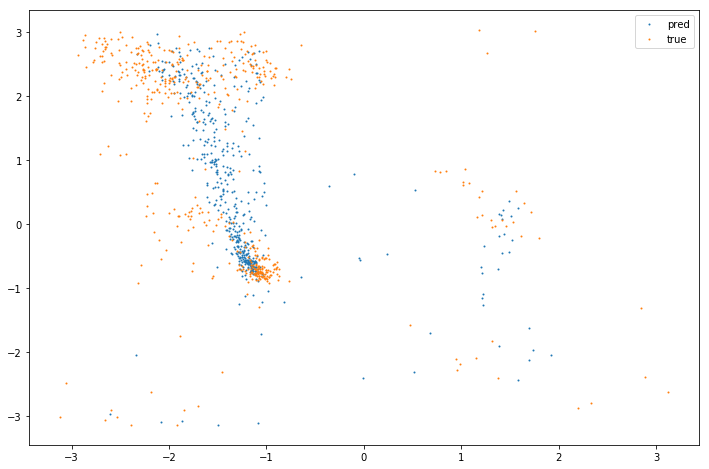

In [33]:
protein_n = 0

plt.figure(figsize=(12,8))

phi, psi, omega = np.split(pred_v, 3, -1)
plt.scatter(phi[:500], psi[:500], s=1, label='pred')

phi, psi, omega = np.split(true_dihedrals_v, 3, -1)
plt.scatter(phi[:500], psi[:500], s=1, label='true')

plt.legend()

In [ ]:
plt.hist(omega[protein_n], bins=100)

In [ ]:
#                 # access trainable variables to see if they're training
#                 variables_names = [v.name for v in tf.trainable_variables()]
#                 values = sess.run(variables_names)
#                 for k, v in zip(variables_names, values):
#                     print("Variable: ", k)
#                     print("Shape: ", v.shape)
#                     print(v)